# Example for Deep k-Nearest Neighbor

## 1. Preparation for DkNN

In [4]:
!pip install falconn

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

from dknn import *
from utils_model import *
from utils_plot import *

import os
import matplotlib
import numpy as np
import tensorflow as tf
from six.moves import xrange


if 'DISPLAY' not in os.environ:
  matplotlib.use('Agg')


In [6]:
# load and preprocess MNIST data
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train/255
X_test = X_test/255

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
print( "Shape of training data: {}".format( X_train.shape))
print( "Shape of training labels: {}".format(y_train.shape))

Shape of training data: (60000, 28, 28, 1)
Shape of training labels: (60000,)


In [7]:
# make shallow CNN for testing
model = make_shallow_basic_cnn()

# compile the model 
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics='accuracy', 
)


In [8]:
# train the model
# if you want specify batch size, learning rates etc.
r = model.fit(X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs = 1,
)

1875/1875 [==============================] - 15s 8ms/step - loss: 0.2144 - accuracy: 0.9395 - val_loss: 0.0840 - val_accuracy: 0.9742


In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                62730     
Total params: 63,050
Trainable params: 63,050
Non-trainable params: 0
_________________________________________________________________


In [10]:
# summarize filter shapes per layer
# we are only interested in convolutional layers
print("Layer names (and shapes) of the model:")
layer_indices = []
nb_layers = []
for i in range(len(model.layers)):
  layer = model.layers[i]
  
	# check for convolutional layer
  if ('conv' not in layer.name) and ('dense' not in layer.name):
    print(layer.name)
    continue
  # get filter weights
  filters, biases = layer.get_weights()
  print(layer.name, filters.shape)
  nb_layers.append(layer.name)
  layer_indices.append(i)


Layer names (and shapes) of the model:
input_1
conv2d (3, 3, 1, 32)
max_pooling2d
flatten
dense (6272, 10)


In [11]:
nb_layers, layer_indices

(['conv2d', 'dense'], [1, 4])

In [12]:
# create the different datasets
# Use a holdout of the test set to simulate calibration data for the DkNN.
train_data = X_train[:10000]
train_labels = y_train[:10000]
print("Shape of training dataset: {}{}".format(train_data.shape, train_labels.shape))

#Number of calibration points for the DkNN
nb_cali = 10

cali_data = X_test[:nb_cali]
y_cali = y_test[:nb_cali]
cali_labels = y_cali
print("Shape of calibration dataset: {}{}".format(cali_data.shape, y_cali.shape))

test_data = X_test[nb_cali:]
y_test = y_test[nb_cali:]
print("Shape of test dataset: {}{}".format(test_data.shape, y_test.shape))



Shape of training dataset: (10000, 28, 28, 1)(10000,)
Shape of calibration dataset: (10, 28, 28, 1)(10,)
Shape of test dataset: (9990, 28, 28, 1)(9990,)


## 2. Perform DkNN

In [13]:
# Define callable that returns a dictionary of all activations for a dataset
def get_activations(data):
  """
  A callable that takes a np array and a layer name and returns its activations on the data.

  :param data: dataset
  :return: data_activations (dictionary of all activations for given dataset)
  """
  data_activations = {}

  # obtain all the predictions on the data by making a multi-output model
  outputs = [model.get_layer(name=layer).output for layer in nb_layers]
  model_mult = Model(inputs=model.inputs, outputs=outputs)

  # use the model for predictions (returns a list)
  predictions = model_mult.predict(data)

  for i in range(len(predictions)):
    pred = predictions[i]
    layer = nb_layers[i]

    # number of samples
    num_samples = pred.shape[0]

    # given the first dimension, numpy reshape has to deduce the other shape
    reshaped_pred = pred.reshape(num_samples, -1)

    data_activations[layer] = reshaped_pred
  return data_activations

In [14]:
# Wrap the model into a DkNNModel
neighbors = 5

dknn = DkNNModel(
  neighbors = neighbors,
  layers = nb_layers,
  get_activations = get_activations,
  train_data = train_data,
  train_labels = train_labels,
)

Getting activations for training data
Received activations for training data
Initializing locality-sensitive hashing
Constructing the NearestNeighbor table
dimension for tables is  25088
Constructing the NearestNeighbor table
dimension for tables is  10


In [15]:
print("Start model calibration")
dknn.calibrate(cali_data, cali_labels)
print("Calibrated the model")

Start model calibration
Starting calibration of DkNN.
cali_knns_ind.values() dict_values([array([[9724, 6525, 9444, 1673,  522],
       [1609, 2184, 5908,  360, 5816],
       [6380, 5732, 1658, 1697, 2301],
       [2327, 4356, 1877, 8982, 6357],
       [ 914, 3998, 9026, 5406,  194],
       [3468, 9815, 9312, 6989, 2870],
       [  54, 3280, 2827,  272, 4633],
       [4544, 4368, 3186, 2520, 4158],
       [9500, 9948, 1398, 2868, 5056],
       [5044, 3970, 9469, 2453, 4065]], dtype=int32), array([[6435,  522, 2173,  994, 3894],
       [5908, 7554, 4514, 2738, 5816],
       [9875, 9011, 7303, 2663, 3771],
       [4748, 3702, 6113, 4356, 9922],
       [3608, 3761, 3990, 8412,  402],
       [2166, 3889,  573, 9312, 3468],
       [8457, 7296, 9513, 9410, 5105],
       [5024, 5898, 4368, 7922, 1962],
       [ 958, 8414, 3288, 7294, 8814],
       [5044, 9347, 8671, 1291, 6999]], dtype=int32)])
cali_knns_labels.values() dict_values([array([[7, 7, 7, 7, 7],
       [2, 2, 2, 2, 2],
       [1, 1

In [16]:
# Test the DkNN on clean test data
#Only on limited data for now because of limited resources
print("Shape of used test data: {}".format(test_data[:2].shape))
dknn_preds = dknn.fprop_np(test_data[:2])
print("Credibility (=how relevant the training set is to the prediction): {}".format(dknn_preds))
print("Shape of credibility: {}".format(dknn_preds.shape))


Shape of used test data: (2, 28, 28, 1)
Credibility (=how relevant the training set is to the prediction): [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
Shape of credibility: (2, 10)


Shape of used labels: (2,)
Mean of predicted labels = true labels: 1.0
Saving reliability diagram at: /tmp/dknn_.pdf
(2,) (2,)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0]
[0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 2]
2


/home/ani/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ani/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


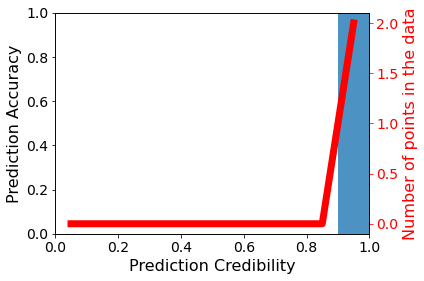

In [17]:
print("Shape of used labels: {}".format(y_test[:2].shape))
print("Mean of predicted labels = true labels: {}".format(np.mean(np.argmax(dknn_preds, axis=1) == (y_test[:2]))))
plot_reliability_diagram(dknn_preds, (y_test[:2]), '/tmp/dknn_' + '.pdf')

Shape of data: (2, 28, 28, 1) (from dataset test)
Shape of credibility: (2, 10)
Mean of predicted labels = true labels: 1.0
Saving reliability diagram at: /tmp/dknn_test.pdf
(2,) (2,)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0]
[0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 2]
2


/home/ani/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ani/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Shape of data: (2, 28, 28, 1) (from dataset cali)
Shape of credibility: (2, 10)
Mean of predicted labels = true labels: 0.0
Saving reliability diagram at: /tmp/dknn_cali.pdf
(2,) (2,)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 2]
2


/home/ani/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ani/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


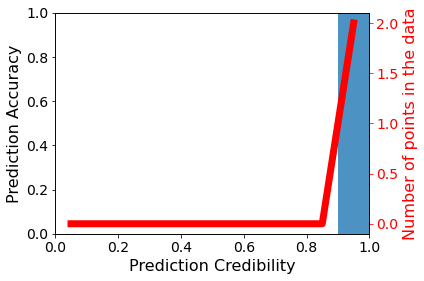

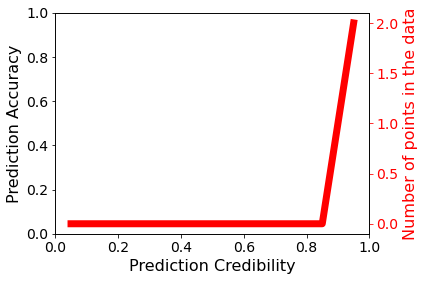

In [18]:
amount_data = 4
for data_in, fname in zip([test_data[:amount_data]], ['test']):
  print("Shape of data: {} (from dataset {})".format(data_in.shape, fname))
  dknn_preds = dknn.fprop_np(data_in)
  print("Shape of credibility: {}".format(dknn_preds.shape))
  print("Mean of predicted labels = true labels: {}".format(np.mean(np.argmax(dknn_preds, axis=1) == (y_test[:amount_data]))))
  plot_reliability_diagram(dknn_preds, y_test[:amount_data], '/tmp/dknn_' + fname + '.pdf')

for data_in, fname in zip([cali_data[:amount_data]], ['cali']):
  print("Shape of data: {} (from dataset {})".format(data_in.shape, fname))
  dknn_preds = dknn.fprop_np(data_in)
  print("Shape of credibility: {}".format(dknn_preds.shape))
  print("Mean of predicted labels = true labels: {}".format(np.mean(np.argmax(dknn_preds, axis=1) == (cali_labels[:amount_data]))))
  plot_reliability_diagram(dknn_preds, cali_labels[:amount_data], '/tmp/dknn_' + fname + '.pdf')


In [19]:
dknn.query_objects

{'conv2d': <dknn.NearestNeighbor at 0x7fa7f35319d0>,
 'dense': <dknn.NearestNeighbor at 0x7fa7f3529970>}